<a href="https://colab.research.google.com/github/c3qian/Hello-Chao/blob/master/Chao_OCR.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Convolutional Recurrent Neural Network (CRNN) for OCR


Steps for OCR:

1. Preprocessing Data
2. Creating Network Architecture(CTC loss function)
3. Training Model
4. Test Model

###Import

In [1]:
import os
import fnmatch
import cv2
import numpy as np
import string
import time

from keras.preprocessing.sequence import pad_sequences

from keras.layers import Dense, LSTM, Reshape, BatchNormalization, Input, Conv2D, MaxPool2D, Lambda, Bidirectional
from keras.models import Model
from keras.activations import relu, sigmoid, softmax
import keras.backend as K
from keras.utils import to_categorical
from keras.callbacks import ModelCheckpoint
import tensorflow as tf

#ignore warnings in the output
tf.logging.set_verbosity(tf.logging.ERROR)
from tensorflow.python.client import device_lib

# Check all available devices if GPU is available
print(device_lib.list_local_devices())
sess = tf.Session(config=tf.ConfigProto(log_device_placement=True))

from glob import glob
 
import matplotlib.pyplot as plt 

Using TensorFlow backend.


[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 3406356911365021906
, name: "/device:XLA_CPU:0"
device_type: "XLA_CPU"
memory_limit: 17179869184
locality {
}
incarnation: 11641911842688634676
physical_device_desc: "device: XLA_CPU device"
, name: "/device:XLA_GPU:0"
device_type: "XLA_GPU"
memory_limit: 17179869184
locality {
}
incarnation: 3531102088120465099
physical_device_desc: "device: XLA_GPU device"
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 11326753997
locality {
  bus_id: 1
  links {
  }
}
incarnation: 8831939635512936401
physical_device_desc: "device: 0, name: Tesla K80, pci bus id: 0000:00:04.0, compute capability: 3.7"
]


### Preprocessing

1. Download and unzip the dataset into a folder
2. Preprocess the data: both inputs and outputs

Input:

*   Read the images and convert them into gray-scale images(why?)
*   Reshape each image to size (128,32) (why?)
*   Expand the dimension of the image from (128,32) to (128,32,1) (why?)
*   Normalize the image pixel values by dividing it with 255

Output:

*   Read the image file names as the labels of that image
*   Encode word into digits using a map (‘a’:0, ‘b’:1 …….. ‘z’:26 ......) e.g.  "aabb" -> [0,0,1,1]
*   Find the maximum length among all words and pad every label to be the same size(max size) 



In [2]:
!wget https://transfer.sh/ZHMV4/dataset.zip
!unzip dataset.zip


--2019-07-13 15:56:00--  https://transfer.sh/ZHMV4/dataset.zip
Resolving transfer.sh (transfer.sh)... 144.76.136.153
Connecting to transfer.sh (transfer.sh)|144.76.136.153|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 6534503 (6.2M) [application/zip]
Saving to: ‘dataset.zip.2’

dataset.zip.2       100%[===================>]   6.23M  2.60MB/s    in 2.4s    

2019-07-13 15:56:07 (2.60 MB/s) - ‘dataset.zip.2’ saved [6534503/6534503]

Archive:  dataset.zip
replace dataset/.DS_Store? [y]es, [n]o, [A]ll, [N]one, [r]ename: n
replace __MACOSX/dataset/._.DS_Store? [y]es, [n]o, [A]ll, [N]one, [r]ename: N


In [2]:
# char_list:   'abcdefghijklmnopqrstuvwxyzABCDEFGHIJKLMNOPQRSTUVWXYZ0123456789'
char_list = string.ascii_letters+string.digits
print('char_list:',char_list)
print('total length:', len(char_list))
 
# every word is encoded as a list of digits
# the digit for each character is represented by the index
# e.g. aabb -> [0,0,1,1], index of a is 0, index of b is 1

def encode_to_labels(txt):
    # encoding each output word into digits
    dig_lst = []
    for i in txt:
      dig_lst.append(char_list.index(i))
    return dig_lst

char_list: abcdefghijklmnopqrstuvwxyzABCDEFGHIJKLMNOPQRSTUVWXYZ0123456789
total length: 62


In [0]:
path = 'dataset/'
 
#lists for training dataset
train_x = []
train_y = []
train_x_len = []
train_y_len = []
orig_y = []
 
#lists for validation dataset
val_x = []
val_y = []
val_x_len = []
val_y_len = []
val_orig_y = []
 
max_label_len = 0
 
flag = 0
 
for i, f_name in enumerate(glob(os.path.join(path,'*/*.jpg'))):
    # read input image and convert into gray scale image
    img = cv2.imread(f_name, 0)
    #img = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    # convert each image of shape (32, 128, 1)
    # hint: cv2.resize, np.expand_dims
    
    
    
   
    img = cv2.resize(img, (128,32))
    img = np.expand_dims(img, axis =2) 
    # Normalize each image
    img = img/255

    # get the text from the image
    txt = os.path.basename(f_name).split('_')[1]

    # compute maximum length of the text
    if len(txt) > max_label_len:
        max_label_len = len(txt)


    # split the data into validation and training dataset as 1:9
    if np.random.rand() < 0.1:     
        val_x.append(img)
        val_y.append(encode_to_labels(txt))
        val_x_len.append(31)
        val_y_len.append(len(txt))
        val_orig_y.append(txt)  
    else:
        train_x.append(img)
        train_y.append(encode_to_labels(txt)) 
        train_x_len.append(31)
        train_y_len.append(len(txt))
        orig_y.append(txt)


Number of training data: 2878
Number of validation data: 323
(32, 128, 1)
Label value:  [27, 0, 11, 11, 14, 14, 13, 8, 18, 19, 18]
Raw Label value:  Balloonists


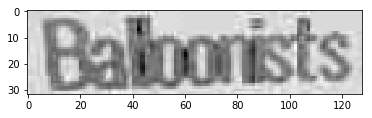

In [6]:
# Check your preprocessing results
print('Number of training data:',len(train_x))
print('Number of validation data:',len(val_x))

print(train_x[1].shape)
plt.imshow(train_x[1][:,:,0], cmap='gray')
print('Label value: ',train_y[1])
print('Raw Label value: ', orig_y[1])

In [0]:

  
# pad each output label to maximum text length
# use "post" padding
# this is not zero padding, we want to pad a specific value: len(char_list)
 
train_padded_y = pad_sequences(train_y , maxlen = max_label_len,dtype = "int32",
  padding = "post", value = len(char_list))
val_padded_y = pad_sequences(val_y , maxlen = max_label_len,dtype = "int32",
  padding = "post", value = len(char_list))

### Network Archtecture

Paper link: (https://arxiv.org/pdf/1507.05717.pdf)

1. Input shape (32,128,1)
2. Use CNN to produce feature map
5. Make feature map compatible with LSTM layer.
6. Use two Bidirectional LSTM layers each of which has 128 units. 

In [0]:
# input with shape of height=32 and width=128 
inputs = Input(shape=(32,128,1), name='net_input')
 
# Conv2D: 64 filters, (3,3) kernels, rectified unit, use "same" padding
# Pooling: (2,2) size, stride 2
conv_1 = Conv2D(64, (3,3), activation = 'relu', padding='same')(inputs)
pool_1 = MaxPool2D(pool_size=(2, 2), strides=2)(conv_1)
 
conv_2 = Conv2D(128, (3,3), activation = 'relu', padding='same')(pool_1)
pool_2 = MaxPool2D(pool_size=(2, 2), strides=2)(conv_2)
 
conv_3 = Conv2D(256, (3,3), activation = 'relu', padding='same')(pool_2)
 
conv_4 = Conv2D(256, (3,3), activation = 'relu', padding='same')(conv_3)
pool_4 = MaxPool2D(pool_size=(2, 1))(conv_4)
 
conv_5 = Conv2D(512, (3,3), activation = 'relu', padding='same')(pool_4)
# Batch normalization layer, 
# blog: https://towardsdatascience.com/batch-normalization-in-neural-networks-1ac91516821c
batch_norm_5 = BatchNormalization()(conv_5)
 
conv_6 = Conv2D(512, (3,3), activation = 'relu', padding='same')(batch_norm_5)
batch_norm_6 = BatchNormalization()(conv_6)
pool_6 = MaxPool2D(pool_size=(2, 1))(batch_norm_6)
 
conv_7 = Conv2D(512, (2,2), activation = 'relu')(pool_6)
 
# reduce the dimension
squeezed = Lambda(lambda x: K.squeeze(x, 1))(conv_7)
 
# bidirectional LSTM layers with units=128
# we want to return sequences, not the last output
# use dropout 0.2
blstm_1 = Bidirectional(LSTM(128, return_sequences=True),input_shape=(32,128, 1))(squeezed)
blstm_2 = Bidirectional(LSTM(128, return_sequences=True),input_shape=(32,128, 1))(blstm_1)
 
# our final output has [len(char_list)+1] classes
# we need to use softmax as the activation function
num_classes = len(char_list)+1
outputs = Dense(num_classes, activation='softmax')(blstm_2)


# model to be used at test time
act_model = Model(inputs, outputs)

In [23]:

act_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
net_input (InputLayer)       (None, 32, 128, 1)        0         
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 32, 128, 64)       640       
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 16, 64, 64)        0         
_________________________________________________________________
conv2d_11 (Conv2D)           (None, 16, 64, 128)       73856     
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 8, 32, 128)        0         
_________________________________________________________________
conv2d_12 (Conv2D)           (None, 8, 32, 256)        295168    
_________________________________________________________________
conv2d_13 (Conv2D)           (None, 8, 32, 256)        590080    
__________

### Loss Function

CTC Details: (https://theailearner.com/2019/05/29/connectionist-temporal-classificationctc/).

In [0]:
labels = Input(name='the_labels', shape=[max_label_len], dtype='float32')
input_length = Input(name='input_length', shape=[1], dtype='int64')
label_length = Input(name='label_length', shape=[1], dtype='int64')
 
def ctc_lambda_func(args):
    y_pred, labels, input_length, label_length = args
 
    return K.ctc_batch_cost(labels, y_pred, input_length, label_length)
 
loss_out = Lambda(ctc_lambda_func, output_shape=(1,), name='ctc')([outputs, labels, input_length, label_length])

#model to be used at training time
model = Model(inputs=[inputs, labels, input_length, label_length], outputs=loss_out)

### train the Model

In [0]:
model.compile(loss={'ctc': lambda y_true, y_pred: y_pred}, optimizer = 'adam')
 
# this is a keras functionality, after each epoch if we find the current model 
# has the lowest loss so far, we will save the model
filepath="best_model.hdf5"
checkpoint = ModelCheckpoint(filepath=filepath, monitor='val_loss', verbose=1, save_best_only=True, mode='auto')
callbacks_list = [checkpoint]

In [0]:
# convert list to np array
train_x = np.array(train_x)
train_x_len = np.array(train_x_len)
train_y_len = np.array(train_y_len)

val_x = np.array(val_x)
val_x_len = np.array(val_x_len)
val_y_len = np.array(val_y_len)

In [27]:
batch_size = 256
epochs = 10
# actually start the training
model.fit(x=[train_x, train_padded_y, train_x_len, train_y_len], y=np.zeros(len(train_x)), batch_size=batch_size, epochs = epochs, validation_data = ([val_x, val_padded_y, val_x_len, val_y_len], [np.zeros(len(val_x))]), verbose = 1, callbacks = callbacks_list)

Train on 2878 samples, validate on 323 samples
Epoch 1/10
2878/2878 [==============================] - 24s 8ms/step - loss: 43.5906 - val_loss: 31.2690

Epoch 00001: val_loss improved from inf to 31.26899, saving model to best_model.hdf5
Epoch 2/10
2878/2878 [==============================] - 10s 3ms/step - loss: 31.8967 - val_loss: 30.8036

Epoch 00002: val_loss improved from 31.26899 to 30.80361, saving model to best_model.hdf5
Epoch 3/10
2878/2878 [==============================] - 10s 3ms/step - loss: 31.4903 - val_loss: 30.6368

Epoch 00003: val_loss improved from 30.80361 to 30.63685, saving model to best_model.hdf5
Epoch 4/10
2878/2878 [==============================] - 10s 3ms/step - loss: 31.2667 - val_loss: 30.3959

Epoch 00004: val_loss improved from 30.63685 to 30.39592, saving model to best_model.hdf5
Epoch 5/10
2878/2878 [==============================] - 10s 3ms/step - loss: 31.0680 - val_loss: 30.1895

Epoch 00005: val_loss improved from 30.39592 to 30.18946, saving mod

### Test the Model

In [29]:
# load the saved best model weights
act_model.load_weights('best_model.hdf5')
 
# predict outputs on validation images
prediction = act_model.predict(val_x[:10])
 
# use CTC decoder
out = K.get_value(K.ctc_decode(prediction, input_length=np.ones(prediction.shape[0])*prediction.shape[1],
                         greedy=True)[0][0])

# see the results
i = 0
for x in out:
    print("original_text =  ", val_orig_y[i])
    print("predicted text = ", end = '')
    for p in x:  
        if int(p) != -1:
            print(char_list[int(p)], end = '')       
    print('\n')
    i+=1

original_text =   Incas
predicted text = 

original_text =   Sufficing
predicted text = 

original_text =   PETIT
predicted text = 

original_text =   contagious
predicted text = 

original_text =   MORRIS
predicted text = 

original_text =   Fathead
predicted text = 

original_text =   Lollies
predicted text = 

original_text =   staider
predicted text = 

original_text =   Puss
predicted text = 

original_text =   Oars
predicted text = 

